In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import os
import sys

sys.path.append('..')

from utils import dataset

In [474]:
train_dist = dataset.LabeledDataset.load('../data/center_crop_64_mobilenet_v3_small_embeddings.npz')
train_dist_128 = dataset.LabeledDataset.load('../data/resize_256_center_crop_128_mobilenet_v3_small_embeddings.npz')
pub_dist = dataset.LabeledDataset.load('../data/pub_test_predictions_embeds_crop_64_proj_64.npz')
private_dist = dataset.LabeledDataset.load('../data/private_test_predictions_embeds_crop_64_proj_64.npz')
private_dist_128 = dataset.LabeledDataset.load('../data/private_test_predictions_embeds_crop_128_proj_64.npz')

In [3]:
train_dist.samples.shape, pub_dist.samples.shape, private_dist.samples.shape

((13404, 1000), (1502, 1000), (15058, 1000))

In [4]:
def normalize(d : dataset.LabeledDataset):
    import copy
    dp = copy.copy(d)
    dp.samples = d.samples / np.sum(np.abs(d.samples), axis=1, keepdims=True)
    return dp

In [5]:
train_n_private = dataset.LabeledDataset.merge(
    normalize(train_dist),
    normalize(private_dist)
)

In [779]:
private_1_6_128 = normalize(private_dist_128.subset(np.where(golden_predictions == "1")))

In [479]:
private_dist_128.labels = np.zeros((private_dist_128.labels.shape[0], 2))

In [480]:
train_n_private_128 = dataset.LabeledDataset.merge(
    normalize(train_dist_128),
    normalize(private_dist_128)
)

In [6]:
from sklearn.decomposition import PCA

In [7]:
train_n_private_2d = PCA(n_components=2).fit_transform(train_n_private.samples)

In [481]:
train_n_private_128_2d = PCA(n_components=2).fit_transform(train_n_private_128.samples)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
N_TRAIN = train_dist.samples.shape[0]

In [10]:
class0 = np.where(train_dist.labels[:, 0] == 'NR')
class1 = np.where(train_dist.labels[:, 0] == 'ER')

In [15]:
def draw_on_proj(proj):
    plt.figure(figsize=(15,8))
    plt.plot(
        proj[N_TRAIN:, 0], 
        proj[N_TRAIN:, 1], '*', label='private')
    plt.plot(
        proj[:N_TRAIN, 0][class0], 
        proj[:N_TRAIN, 1][class0], '*', label='train-NR')
    plt.plot(
        proj[:N_TRAIN, 0][class1], 
        proj[:N_TRAIN, 1][class1], '*', label='train-ER')
    plt.grid()
    plt.legend()
    plt.show()

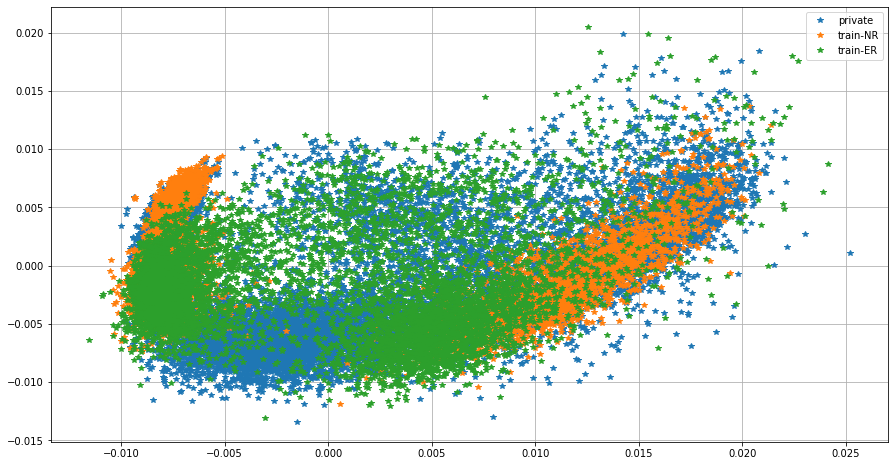

In [16]:
draw_on_proj(train_n_private_2d)

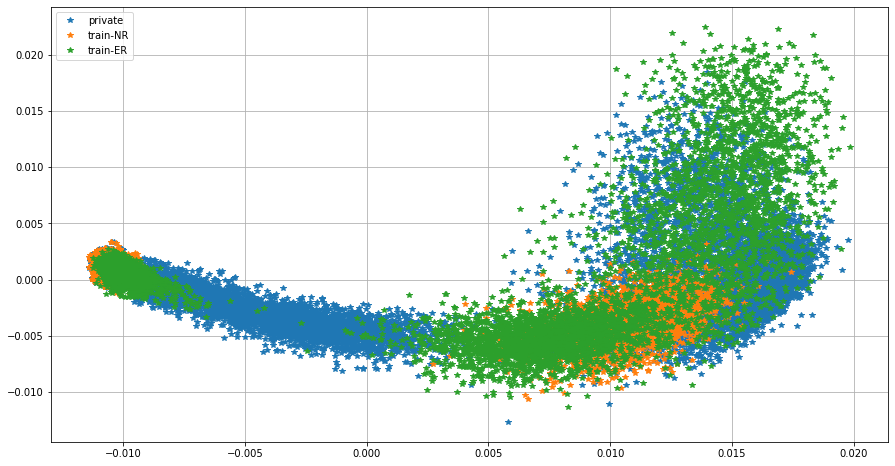

In [482]:
draw_on_proj(train_n_private_128_2d)

In [12]:
from sklearn.manifold import TSNE

In [780]:
%%time
tsne16 = TSNE(n_components=2, n_iter=250, n_jobs=7,random_state=0)

private_1_6_128_tsne = tsne16.fit_transform(
    private_1_6_128.samples)

CPU times: user 1min 1s, sys: 536 ms, total: 1min 2s
Wall time: 21.7 s


In [483]:
%%time
tsne128 = TSNE(n_components=2, n_iter=1000, n_jobs=7,random_state=0)

train_n_private_128_tsne = tsne128.fit_transform(
    train_n_private_128.samples)

CPU times: user 14min 26s, sys: 14.7 s, total: 14min 41s
Wall time: 6min 35s


In [31]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=7,random_state=0)

train_n_private_tsne = tsne.fit_transform(
    train_n_private.samples)

CPU times: user 17min 22s, sys: 17.4 s, total: 17min 39s
Wall time: 8min 4s


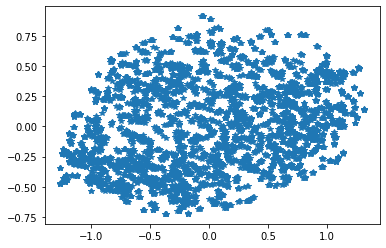

In [781]:
plt.plot(private_1_6_128_tsne[:, 0], private_1_6_128_tsne[:, 1], '*')

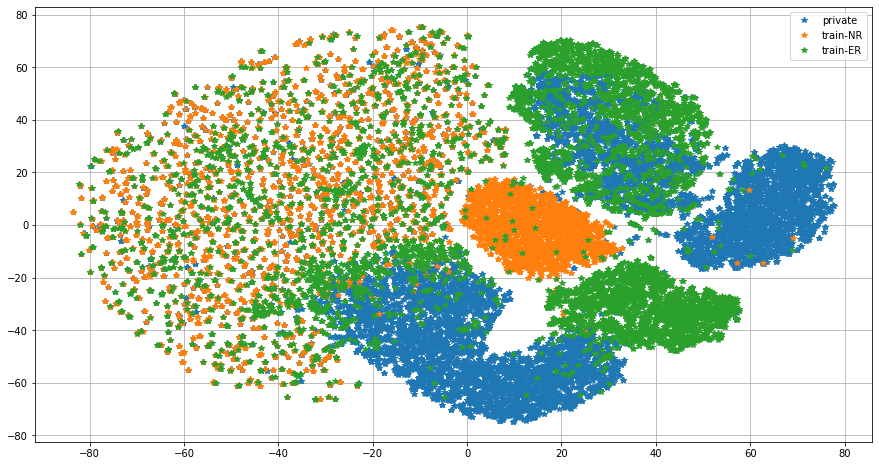

In [484]:
draw_on_proj(train_n_private_128_tsne)

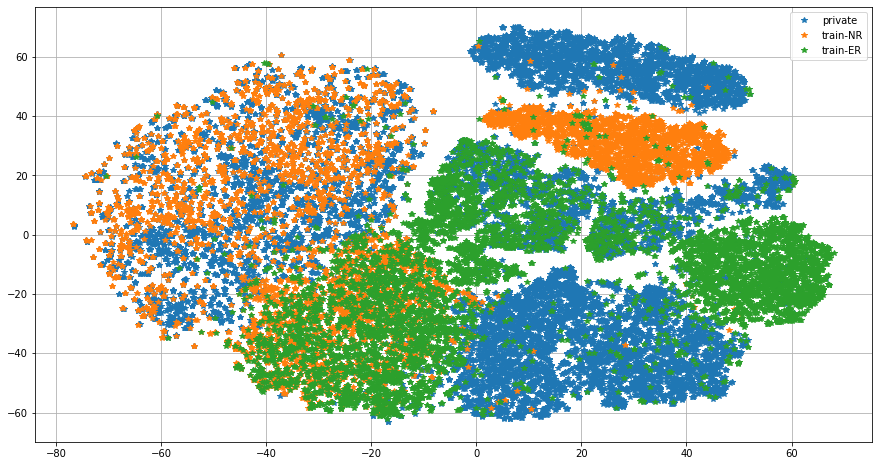

In [32]:
draw_on_proj(train_n_private_tsne)

In [18]:
ens = {}
for en in ['1','3','6','10','20','30']:
    ens[en] = np.where(train_dist.labels[:, 1] == en)

In [28]:
def draw_on_proj_with_classes(proj, with_private_first=False, with_private_last=False):
    plt.figure(figsize=(15,8))
    if with_private_first:
        plt.plot(
            proj[N_TRAIN:, 0], 
            proj[N_TRAIN:, 1], '*', label='private')
    for k,v in ens.items():
        plt.plot(
            proj[:N_TRAIN, 0][v],
            proj[:N_TRAIN, 1][v], '*', label='train-{}'.format(k), alpha=0.5)
    if with_private_last:
        plt.plot(
            proj[N_TRAIN:, 0], 
            proj[N_TRAIN:, 1], '*', label='private')
    plt.grid()
    plt.legend()
    plt.show()

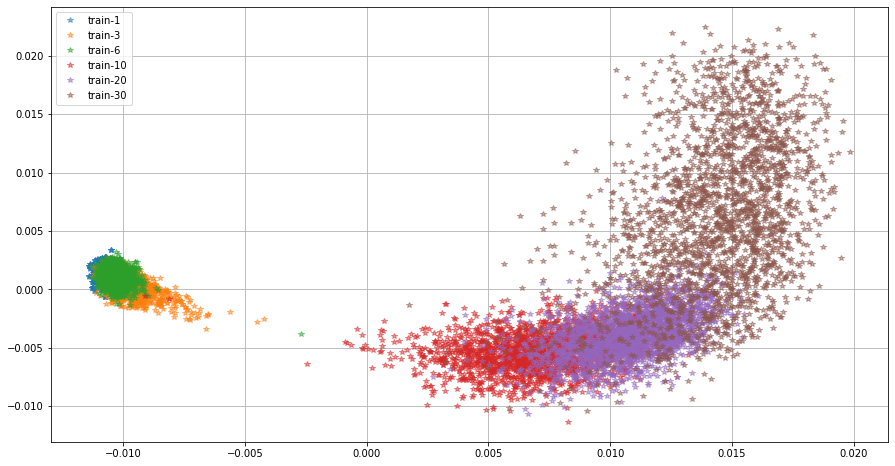

In [485]:
draw_on_proj_with_classes(train_n_private_128_2d)

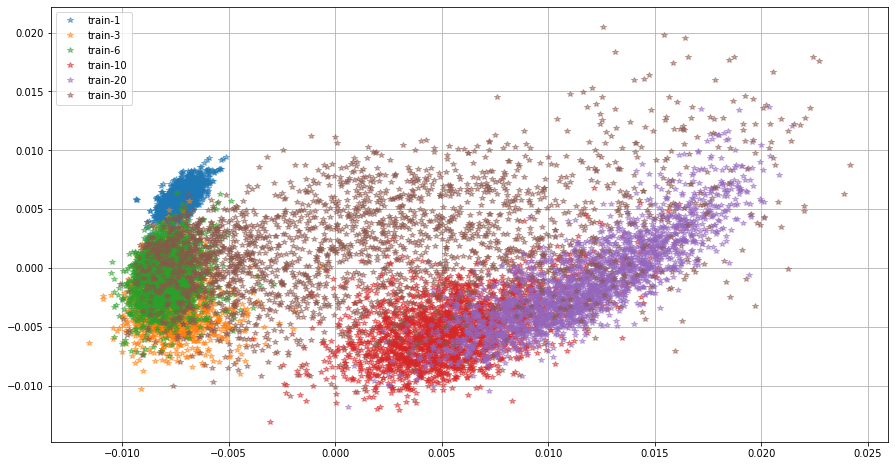

In [20]:
draw_on_proj_with_classes(train_n_private_2d)

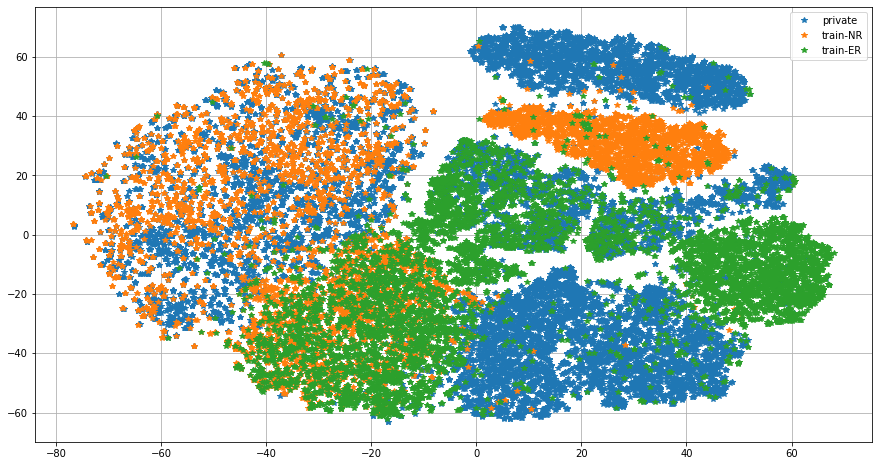

In [33]:
draw_on_proj(train_n_private_tsne)

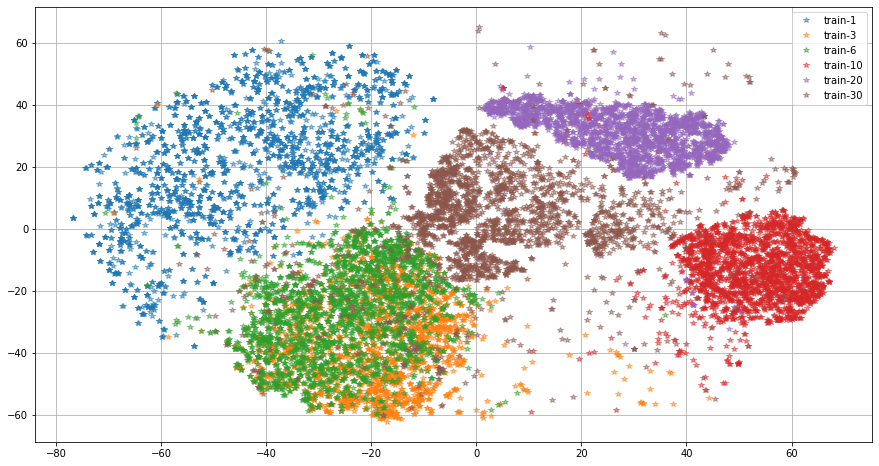

In [34]:
draw_on_proj_with_classes(train_n_private_tsne)

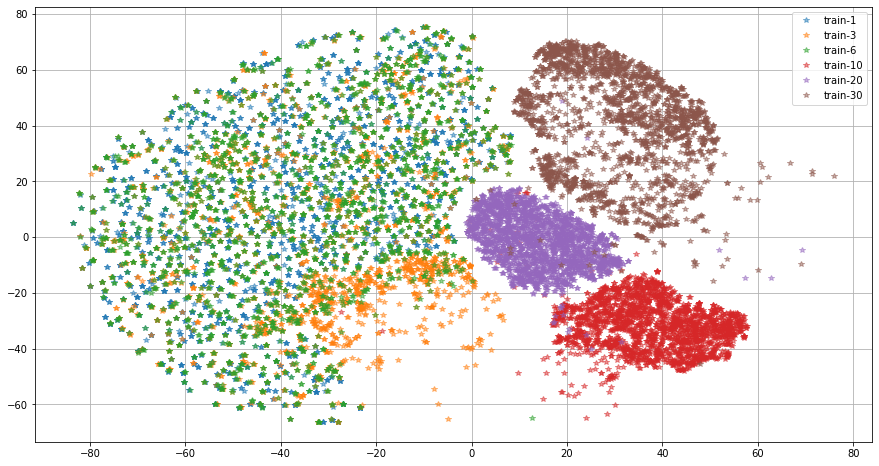

In [486]:
draw_on_proj_with_classes(train_n_private_128_tsne)

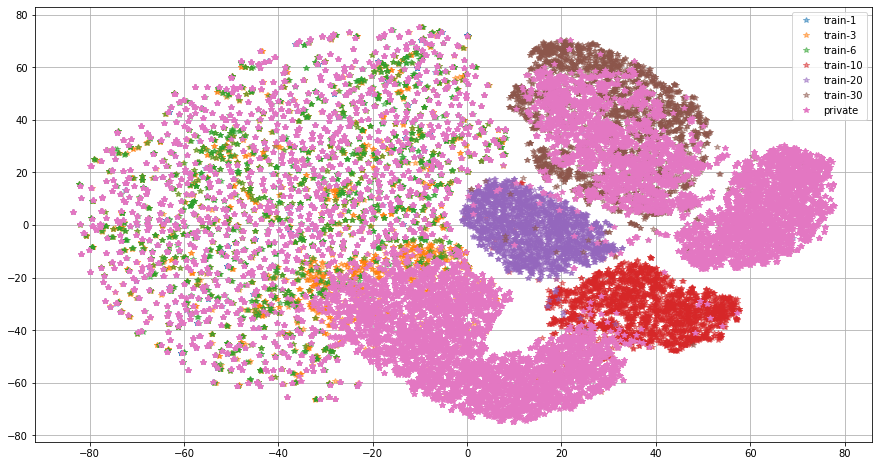

In [488]:
draw_on_proj_with_classes(train_n_private_128_tsne, with_private_last=True)

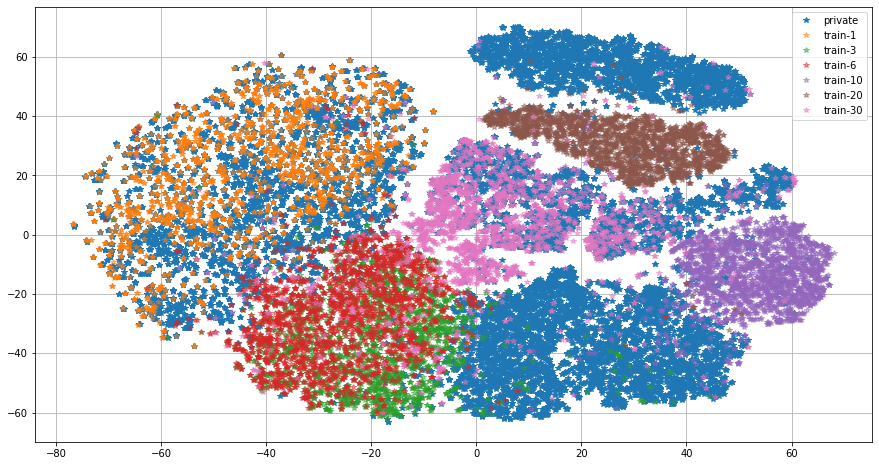

In [35]:
draw_on_proj_with_classes(train_n_private_tsne, with_private_first=True)

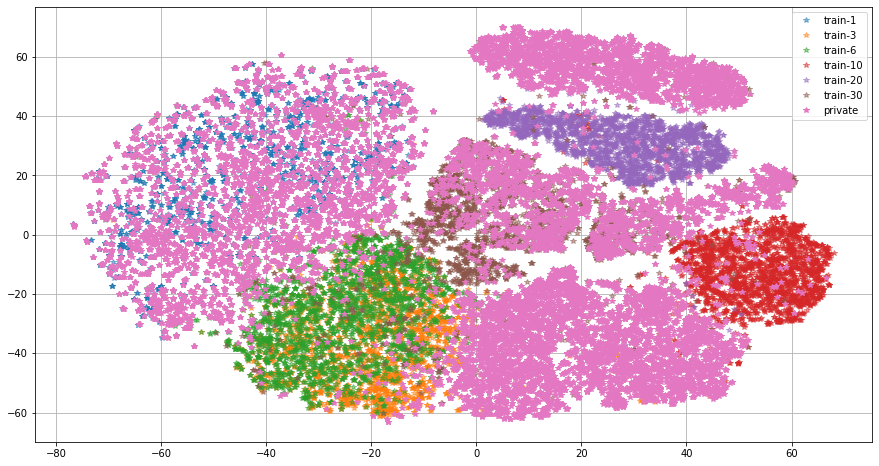

In [36]:
draw_on_proj_with_classes(train_n_private_tsne, with_private_last=True)

In [38]:
import pickle
# save
with open('tsne_seed_0.pkl','wb') as f:
    pickle.dump(tsne,f)

In [75]:
from sklearn.cluster import Birch, KMeans

In [222]:
centers = [
    [5, 20],
    [20, 60],
    [10, 20],
    [15, -20],
    [30, -20],
    [30, 10]
]
centers = np.array(centers)
cluster_fn = KMeans(n_clusters=6,random_state=0, init=centers, max_iter=1)
# cluster_fn = Birch(n_clusters=6)
clusters = cluster_fn.fit_predict(train_n_private_tsne[N_TRAIN:])
print(np.unique(clusters))

[0 1 2 3 4 5]


/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [223]:
from collections import Counter
Counter(clusters)

Counter({0: 4938, 1: 2602, 4: 2618, 2: 1376, 3: 2377, 5: 1147})

In [224]:
cl = {}

for cid in np.unique(clusters):
    cl[cid] = np.where(clusters == cid)

In [261]:
def draw_private_clusters(proj, cl):
    for k,v in cl.items():
        plt.plot(
            proj[:, 0][v],
            proj[:, 1][v], '*', label='cluster-{}'.format(k), alpha=0.25)
        
def add_centers():
    plt.scatter(centers[:, 0], centers[:, 1], np.ones_like(centers[:, 0]) * 100)

def draw_on_proj_with_clusters(
    proj,
    clusters=cl,
    without_train=False,
    with_private_first=False,
    with_private_last=False,
    cluster_train=False
):
    plt.figure(figsize=(15,8))
    if cluster_train:
        draw_private_clusters(proj[:N_TRAIN], clusters)
    if with_private_first:
        draw_private_clusters(proj[N_TRAIN:], clusters)
    if not without_train:
        for k,v in ens.items():
            plt.plot(
                proj[:N_TRAIN, 0][v],
                proj[:N_TRAIN, 1][v], '*', label='train-{}'.format(k), alpha=0.5)
    if with_private_last:
        draw_private_clusters(proj[N_TRAIN:], clusters)
    add_centers()
    plt.grid()
    plt.legend()
    plt.show()

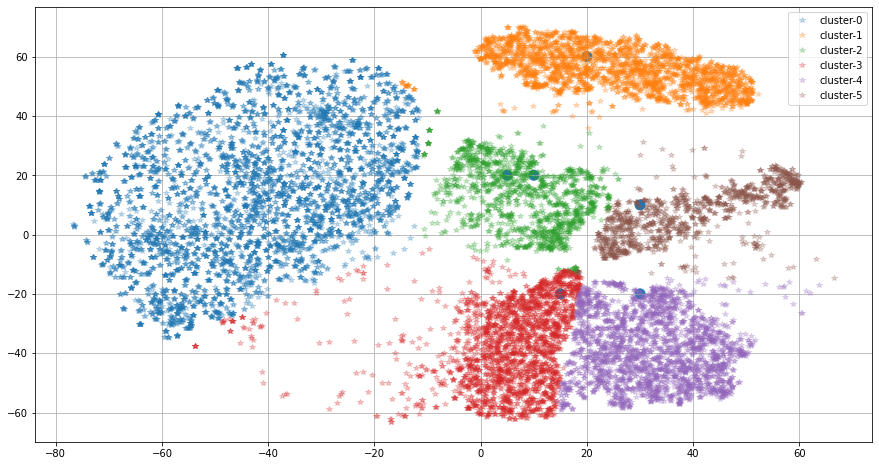

In [228]:
draw_on_proj_with_clusters(train_n_private_tsne, 
                           with_private_last=True, without_train=True)

In [377]:
cluster2energy_mapping = ['1', '20', '30', '6', '3', '10']

In [494]:
def apply_random_projection_and_normalize(data : np.array, to_dim : int = 10, seed : int = 0, normalize=True):
    assert 2 == len(data.shape)
    np.random.seed(seed)
    N = data.shape[1]
    proj_matrix = np.random.randn(N, to_dim) / np.sqrt(N)
#     print(np.mean(proj_matrix), np.std(proj_matrix))
    data_proj = np.matmul(data, proj_matrix)
    if normalize:
        data_proj /= np.sum(np.abs(data_proj), axis=1, keepdims=True)
    return data_proj

In [229]:
from sklearn.neighbors import KNeighborsClassifier

In [379]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(apply_random_projection_and_normalize(train_n_private.samples[N_TRAIN:], to_dim=64),
          [cluster2energy_mapping[c] for c in clusters])

KNeighborsClassifier(n_neighbors=3)

In [380]:
predictions = model.predict(
    apply_random_projection_and_normalize(train_n_private.samples[N_TRAIN:], 64))


In [381]:
predictions

array(['1', '1', '20', ..., '3', '1', '10'], dtype='<U2')

In [382]:
pred = {}

for cid in np.unique(predictions):
    pred[cid] = np.where(predictions == cid)

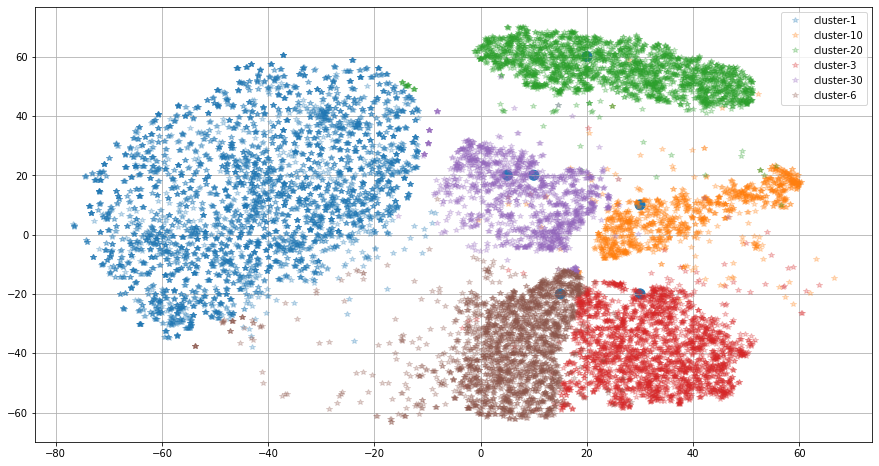

In [383]:
draw_on_proj_with_clusters(train_n_private_tsne, clusters=pred,
                           with_private_last=True, without_train=True)

In [384]:
import pickle
# save
with open('knn_6_test_clusters_3_near_on_64_dim.pkl','wb') as f:
    pickle.dump(model,f)

In [385]:
train_n_private_tsne

array([[-39.606037,  42.179962],
       [-34.19174 , -31.97017 ],
       [ 34.778416,  25.222624],
       ...,
       [ 50.39131 , -39.53534 ],
       [-40.701263,  40.868317],
       [ 55.676247,  11.175032]], dtype=float32)

In [361]:
train_model = KNeighborsClassifier(n_neighbors=3)
train_model.fit(
    apply_random_projection_and_normalize(
        train_n_private.samples[:N_TRAIN],64), train_dist.labels[:, 1])

KNeighborsClassifier(n_neighbors=3)

In [362]:
train_predictions = train_model.predict(apply_random_projection_and_normalize(
        train_n_private.samples[:N_TRAIN],64))

In [363]:
train_pred = {}

for cid in np.unique(train_predictions):
    train_pred[cid] = np.where(train_predictions == cid)

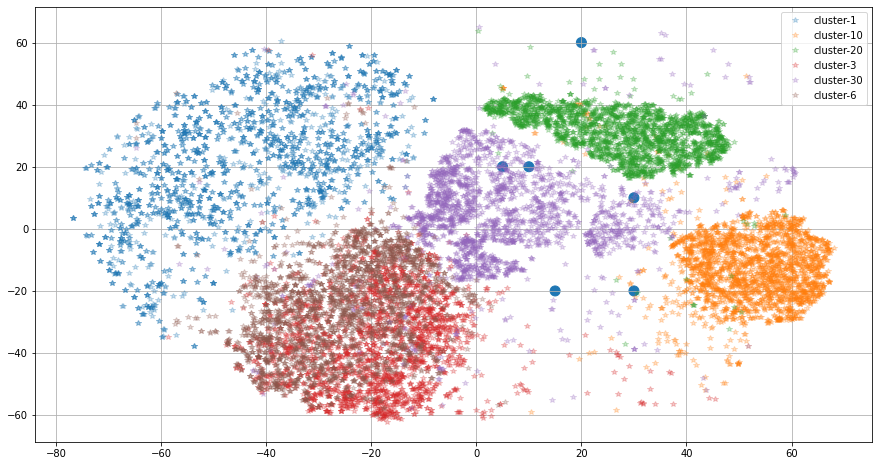

In [364]:
draw_on_proj_with_clusters(train_n_private_tsne, clusters=train_pred, 
                           cluster_train=True, without_train=True)

In [264]:
class_maps = {
"train": {"1" : "NR", "3" : "ER", "6" : "NR", "10" : "ER", "20" : "NR", "30" : "ER"},
"test":  {"1" : "ER", "3" : "NR", "6" : "ER", "10" : "NR", "20" : "ER", "30" : "NR"}
}

In [286]:
train_dist.labels[:10]

array([['NR', '1'],
       ['NR', '6'],
       ['NR', '20'],
       ['NR', '1'],
       ['NR', '1'],
       ['NR', '6'],
       ['NR', '1'],
       ['NR', '20'],
       ['NR', '6'],
       ['NR', '1']], dtype='<U21')

In [359]:
classes = [1, 10, 20, 3, 30, 6]

def mae_scorer(estimator, X, y):
#     y_pred = np.array([sum(z * classes[i] for i,z in enumerate(_y)) for _y in estimator.predict_proba(X)])
    y_pred = np.array([int(_y) for _y in estimator.predict(X)])
    y = np.array([int(_y) for _y in y])
    return -np.mean(np.abs(y_pred - y))

In [365]:
mae_scorer(train_model, apply_random_projection_and_normalize(
        train_n_private.samples[:N_TRAIN],64), train_dist.labels[:, 1])

-0.5137272455983288

In [276]:
train_predictions[:20], train_dist.labels[:, 1][:20]

(array(['1', '6', '20', '1', '1', '6', '1', '20', '3', '1', '20', '6',
        '20', '1', '20', '1', '6', '6', '1', '1'], dtype='<U21'),
 array(['1', '6', '20', '1', '1', '6', '1', '20', '6', '1', '20', '6',
        '20', '1', '20', '1', '6', '6', '1', '1'], dtype='<U21'))

In [370]:
classes = [1, 10, 20, 3, 30, 6]

def calc_probs(estimator, X):
    probs = estimator.predict_proba(X)
    probs_zero = probs[:, 0] + probs[:, 5] + probs[:, 2]
    probs_one = 1 - probs_zero
    return probs_one

In [371]:
train_probs = calc_probs(train_model, apply_random_projection_and_normalize(
        train_n_private.samples[:N_TRAIN],64))

In [368]:
train_dist.labels[:, 0][:10]

array(['NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR'],
      dtype='<U21')

In [372]:
train_probs[:10]

array([0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [373]:
from sklearn.metrics import roc_auc_score

In [375]:
roc_auc_score(y_true=(train_dist.labels[:, 0]=="ER").astype(int),y_score=train_probs)

0.9879696643792263

In [386]:
import pickle
# save
with open('knn_6_train_clusters_3_near_on_64_dim.pkl','wb') as f:
    pickle.dump(train_model,f)

In [388]:
def split_dataset(d : dataset.LabeledDataset):
    ids = np.arange(len(d.samples))
    np.random.seed(0)
    np.random.shuffle(ids)
    N = int(len(ids) * 0.9)
    train_ids = ids[:N]
    val_ids = ids[N:]

    d_learn = d.subset(train_ids)
    d_val = d.subset(val_ids)
    return d_learn, d_val

In [390]:
train = train_n_private.subset(np.arange(N_TRAIN))
learn, val = split_dataset(train)

In [406]:
from sklearn.neighbors import KNeighborsRegressor

In [423]:
# train_model = KNeighborsClassifier(n_neighbors=100)
# train_model.fit(apply_random_projection_and_normalize(
#         learn.samples,64), learn.labels[:, 1])

train_model = KNeighborsRegressor(n_neighbors=1)
train_model.fit(apply_random_projection_and_normalize(
        learn.samples,64), learn.labels[:, 1].astype(int))

KNeighborsRegressor(n_neighbors=1)

In [424]:
np.mean(np.abs(train_model.predict(apply_random_projection_and_normalize(
        val.samples,64)) - val.labels[:, 1].astype(int)))

0.9097688292319165

In [404]:
mae_scorer(train_model, apply_random_projection_and_normalize(
        val.samples,64), val.labels[:, 1])

-1.5548098434004474

In [405]:
val_probs = calc_probs(train_model, apply_random_projection_and_normalize(
        val.samples,64))
roc_auc_score(y_true=(val.labels[:, 0]=="ER").astype(int),y_score=val_probs)

0.9610343523339118

In [425]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [510]:
build_fold = lambda seed: StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
params = {
    "penalty": 'l1',
    "solver": 'saga',
    "verbose": 10,
    "max_iter": 100,
    "tol": 1e-5,
    "scoring" : 'roc_auc',
    "random_state": 0,
    "cv": build_fold(0),
    "n_jobs": 7,
    "refit": False
}

In [428]:
cv_label1 = LogisticRegressionCV(**params).fit(
    X=apply_random_projection_and_normalize(
        train.samples,64),
    y=(train.labels[:, 0] == 'NR').astype(int))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 9 epochs took 0 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 secondsmax_iter reached after 2 seconds

max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 secondsmax_iter reached after 2 seconds

max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   12.9s remaining:   30.0s


max_iter reached after 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
max_iter reached after 2 seconds
convergence after 7 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:   13.0s remaining:   13.0s
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:   13.1s remaining:    5.6s


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   19.9s finished


In [429]:
np.mean(cv_label1.scores_[1],axis=0)  # with crop64 normalized random cv=10

array([0.5       , 0.5       , 0.5       , 0.5       , 0.93023088,
       0.96280139, 0.97065471, 0.97365269, 0.97517403, 0.9761071 ])

In [470]:
cv_label1_test = LogisticRegressionCV(**params).fit(
    X=apply_random_projection_and_normalize(
        private_dist_128.samples,64),
    y=[cluster2energy_mapping[c] in ['1', '6', '20'] for c in clusters])

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds



convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 56 epochs took 1 seconds
convergence after 58 epochs took 1 seconds
max_iter reached after 2 seconds

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 3 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   17.0s remaining:   39.7s
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:   17.3s remaining:   17.3s


max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
convergence after 66 epochs took 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:   17.7s remaining:    7.6s


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   28.2s finished


In [471]:
np.mean(cv_label1_test.scores_[1],axis=0)  # with crop128 normalized random cv=10

array([0.5       , 0.5       , 0.5       , 0.79883113, 0.97655633,
       0.984116  , 0.9862133 , 0.98686506, 0.98717593, 0.98733224])

In [431]:
np.mean(cv_label1_test.scores_[1],axis=0)  # with crop64 normalized random cv=10

array([0.5       , 0.5       , 0.5       , 0.9260799 , 0.97779013,
       0.9879723 , 0.99027993, 0.99108229, 0.9915069 , 0.99180206])

In [523]:
classes = [1, 10, 20, 3, 30, 6]

def mae_scorer(estimator, X, y):
#     y_pred = np.array([sum(z * classes[i] for i,z in enumerate(_y)) for _y in estimator.predict_proba(X)])
    y_pred = np.array([classes[int(_y)] for _y in estimator.predict(X)])
    y = np.array([classes[_y] for _y in y])
    return -np.mean(np.abs(y_pred - y))

In [784]:
import copy

params2 = copy.copy(params)

params2['cv'] = build_fold(1)
params2['scoring'] = mae_scorer
# params2['multi_class'] = "multinomial"
# params2['class_weight'] = "balanced"
# params2['max_iter'] = 100
# params2['penalty'] = 'l1'

# params2['class_weight'] = {str(c) : c for c in classes}
# cv_label2 = LogisticRegressionCV(**params2).fit(
#     apply_random_projection_and_normalize(
#         train_dist_128.samples,64),
#     train.labels[:, 1])

In [685]:
np.mean(cv_label2.scores_['1'],axis=0) # crop128 proj normalized random cv=10

array([-10.92192026, -12.54789041, -11.46380625,  -2.33884554,
        -0.89279687,  -0.42972036,  -0.31498113,  -0.27156138,
        -0.25029834,  -0.23664502])

In [682]:
np.mean(cv_label2_old.scores_['1'],axis=0) # crop128 proj normalized random cv=10

array([-10.92192026, -12.54789041, -10.79639387,  -5.24945569,
        -1.67101178,  -0.88168475,  -0.61832894,  -0.53582245,
        -0.49441784,  -0.46435307])

In [631]:
np.mean(cv_label2.scores_['1'],axis=0) # crop128 proj normalized random cv=10

array([-10.92192026, -12.54789041, -11.46380625,  -2.56473839,
        -0.91130021,  -0.43195894,  -0.31453326,  -0.27290433,
        -0.25111924,  -0.23776414])

In [434]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj normalized random cv=10

array([-10.92192026, -12.54789041, -10.79639387,  -4.73322721,
        -1.67205266,  -0.88369868,  -0.61855282,  -0.53164407,
        -0.49270126,  -0.46286109])

In [506]:
private_dist.samples

array([[-4.3586273 , -0.84242356, -4.919622  , ..., -2.3956423 ,
        -1.3545077 ,  5.394078  ],
       [-4.130948  , -0.727552  , -4.8719473 , ..., -2.1071374 ,
        -1.5472915 ,  5.1533995 ],
       [-3.3926332 , -0.09012794, -4.3314977 , ..., -0.661543  ,
         1.6165684 ,  2.1074185 ],
       ...,
       [-3.7655587 , -1.242555  , -2.883697  , ..., -0.72205627,
         0.55544627,  2.926966  ],
       [-4.1979303 , -0.5086487 , -4.638991  , ..., -2.211808  ,
        -1.4373149 ,  5.014051  ],
       [-3.741756  , -1.2217247 , -2.966744  , ..., -0.5092617 ,
         1.7400771 ,  2.2798674 ]], dtype=float32)

In [505]:
private_dist_128.samples

array([[-2.3889313 ,  0.58207035, -0.9727763 , ..., -2.4240868 ,
         0.6624074 ,  3.5927424 ],
       [-2.2452402 ,  0.66186696, -0.7688269 , ..., -2.196096  ,
         0.590379  ,  3.6005197 ],
       [-0.37605447,  1.9289564 ,  2.0306275 , ..., -0.88690794,
         0.4123469 ,  1.3463355 ],
       ...,
       [-1.484909  ,  0.7486774 ,  0.31267998, ..., -2.038156  ,
         0.18713737,  3.035308  ],
       [-2.3946514 ,  0.75316894, -0.8396269 , ..., -2.291827  ,
         0.65244144,  3.696865  ],
       [ 0.03523731,  1.5504237 ,  2.089231  , ..., -0.7653613 ,
         0.6102469 ,  0.8995141 ]], dtype=float32)

In [514]:
test_concat = np.concatenate([
    apply_random_projection_and_normalize(
        private_dist_128.samples, 64),
    apply_random_projection_and_normalize(
        private_dist.samples, 64)
], axis=1)

In [785]:
cv_label2_test = LogisticRegressionCV(**params2).fit(
    apply_random_projection_and_normalize(
        private_dist.samples, 64), clusters)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds


convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds



convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 seconds

convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 1 seconds
convergence after 3 epochs took 1 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached af

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds
max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds
max_iter reached after 8 seconds
max_iter reached after 9 seconds
max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds
max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds
max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 11 seconds
max_iter reached after 10 seconds
max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds
max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds
max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds
max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds
max_iter reached after 9 seconds
max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds
max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds
max_iter reached after 9 seconds
convergence after 1 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 9 seconds


[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   60.0s remaining:  2.3min
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 seconds
max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:  1.0min remaining:  1.0min


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.1s


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:  1.5min finished


In [787]:
np.mean(cv_label2_test.scores_[1],axis=0) # crop128 proj 32 random cv=10

array([-9.862749  , -8.8921889 , -9.0299505 , -4.35952672, -1.59124543,
       -1.01061601, -0.85621607, -0.84074206, -0.82613383, -0.81749979])

In [496]:
np.mean(cv_label2_test.scores_['1'],axis=0) # crop128 proj normalized 128 random cv=10

array([-7.7557468 , -3.00711087, -1.60466731, -1.03161494, -0.88146131,
       -0.86824295, -0.87408298, -0.87614036, -0.87541065, -0.87979387])

In [542]:
np.mean(cv_label2_test.scores_['1'],axis=0) # crop128 proj normalized random cv=10 balanced

array([-11.31546196, -10.71436363,  -9.34464252,  -2.17997944,
        -1.84132604,  -1.3177271 ,  -1.16249443,  -0.945542  ,
        -0.97468814,  -0.9610971 ])

In [544]:
np.mean(cv_label2_test.scores_['1'],axis=0) # crop64 proj random cv=10

array([-11.31546196, -10.71436363,  -9.34464252,  -1.80867432,
        -0.67220328,  -0.5011942 ,  -0.48751175,  -0.46513252,
        -0.47482654,  -0.45477545])

In [438]:
np.mean(cv_label2_test.scores_['1'],axis=0) # crop64 proj normalized random cv=10

array([-8.54852969, -7.61977843, -7.7557468 , -3.06568009, -0.95265379,
       -0.54170754, -0.47356929, -0.47164463, -0.46593515, -0.45935986])

In [794]:
# save
# with open('cv_label1_tsne_test_v2.pkl','wb') as f:
#     pickle.dump(cv_label1_test,f)
    
# save
with open('cv_label2_tsne_test_v4.pkl','rb') as f:
    test_model = pickle.load(f)

In [730]:
Counter(cv_label2_old.predict(apply_random_projection_and_normalize(
        pub_dist.samples,64)))

Counter({'6': 281, '30': 232, '20': 252, '3': 229, '1': 257, '10': 251})

In [795]:
golden_predictions_v1 = test_model.predict(apply_random_projection_and_normalize(
        private_dist.samples,64))

In [731]:
predictions = cv_label2.predict_proba(apply_random_projection_and_normalize(
        private_dist_128.samples,64))

golden_predictions = cv_label2_test.predict(apply_random_projection_and_normalize(
        private_dist.samples,64))

In [790]:
Counter(golden_predictions_v1)

Counter({0: 5025, 1: 2580, 4: 2588, 5: 1141, 2: 1334, 3: 2390})

In [716]:
def normalize_probs(probs, prior=None):
    if prior is None:
        prior = [x[0] for x in \
 sorted([(x,y) for x,y in Counter(np.argmax(probs,axis=1)).items()], key=lambda x: x[1])]
        print(prior)
    NEED = int(probs.shape[0] / 6)

    used = np.zeros(probs.shape[0], dtype=int)
    result = np.zeros(probs.shape[0], dtype=int)

    for c in prior[::-1]:
        candidates = np.argsort(probs[:, c] * (1 - used))[-NEED:]
        print(classes[c], c, probs[:, c][candidates[0]])
        result[candidates] = c
        used[candidates] = 1
    
    return result

In [590]:
golden_predictions_v1_normed = np.array([str(classes[c]) for c in \
                                normalize_probs(golden_predictions_v1)])

In [606]:
Counter(np.array([str(classes[x]) for x in np.argmax(golden_predictions_v1,axis=1)]))

Counter({'1': 4988, '20': 2560, '3': 2556, '10': 1187, '30': 1340, '6': 2427})

In [591]:
Counter(golden_predictions_v1_normed)

Counter({'10': 2509, '1': 2513, '20': 2509, '3': 2509, '30': 2509, '6': 2509})

In [796]:
pred = {}

for cid in np.unique(golden_predictions_v1):
    pred[cid] = np.where(golden_predictions_v1 == cid)

In [643]:
pred = {}

for cid in np.unique(golden_predictions):
    pred[cid] = np.where(
        np.array([str(classes[x]) for x in np.argmax(predictions,axis=1)]) \
            == cid)

In [725]:
predictions_normed = normalize_probs(predictions, [4, 0, 3, 5, 1, 2])

20 2 0.019172229669222565
10 1 0.05817463095664083
6 5 0.16790824533298895
3 3 0.08099124727673847
1 0 0.8495304864144905
30 4 1.0943574185050163e-05


In [726]:
predictions_normed = np.array([
        str(classes[x]) for x in predictions_normed])

In [727]:
pred_normed = {}

for cid in np.unique(golden_predictions):
    pred_normed[cid] = np.where(
         predictions_normed == cid)

In [714]:
Counter(predictions_normed)

Counter({'1': 2513, '20': 2509, '6': 2509, '10': 2509, '30': 2509, '3': 2509})

In [593]:
golden_predictions_v1_normed

array(['10', '1', '20', ..., '3', '1', '10'], dtype='<U2')

In [605]:
pred["20"][0].shape, pred_normed["20"][0].shape

((2560,), (2509,))

In [782]:
# Counter(
allc = cv_label2_old.predict_proba(apply_random_projection_and_normalize(
    private_dist.samples[np.where(golden_predictions == "1")], 64))[:, 0]
#     )
onel = np.where(golden_predictions == "1")

In [783]:
np.median(allc)

0.8917060795671146

In [762]:
np.where(allc > 0.89)

(array([   0,    1,    2, ..., 4985, 4986, 4987]),)

In [764]:
onel

(array([    0,     1,     3, ..., 15042, 15051, 15056]),)

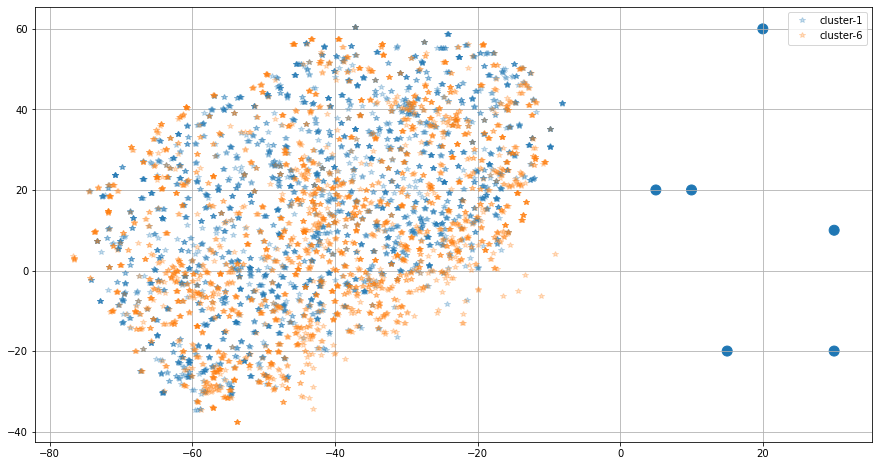

In [769]:
draw_on_proj_with_clusters(train_n_private_tsne, {"1": onel[0][allc > 0.86], "6": onel[0][allc <= 0.86]}, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

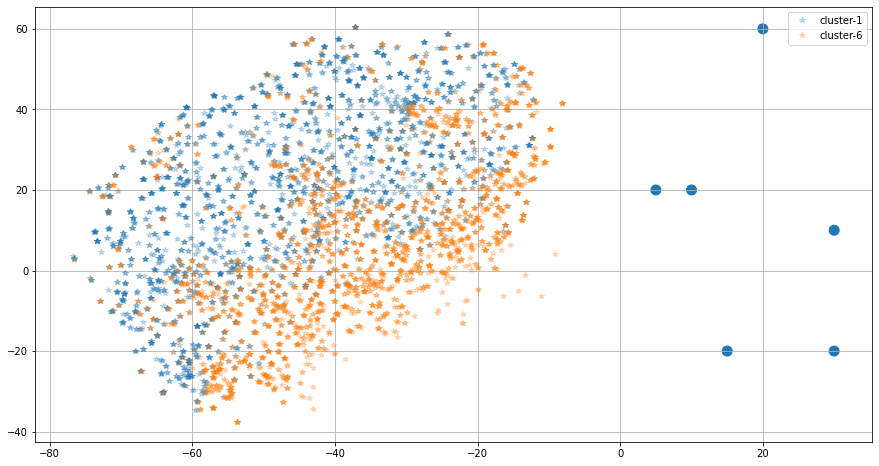

In [765]:
draw_on_proj_with_clusters(train_n_private_tsne, {"1": onel[0][allc > 0.89], "6": onel[0][allc <= 0.89]}, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

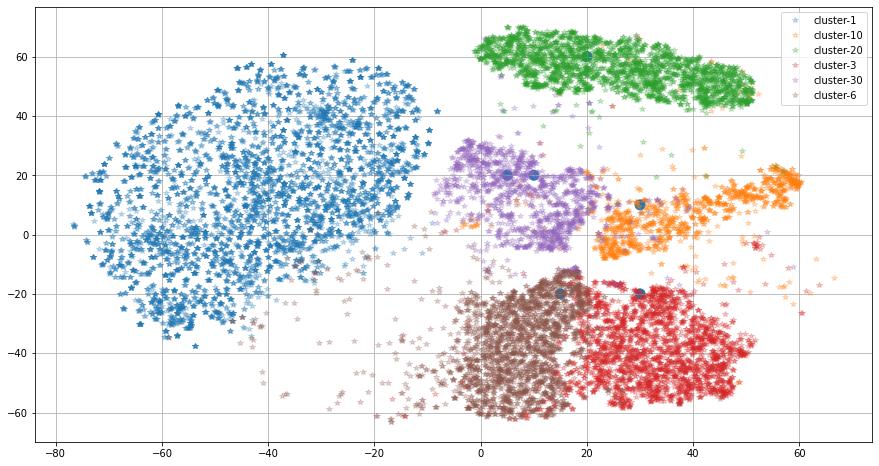

In [734]:
draw_on_proj_with_clusters(train_n_private_tsne, {"1": np.where(allc > 0.89), "6": np.where(allc <= 0.89)}, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

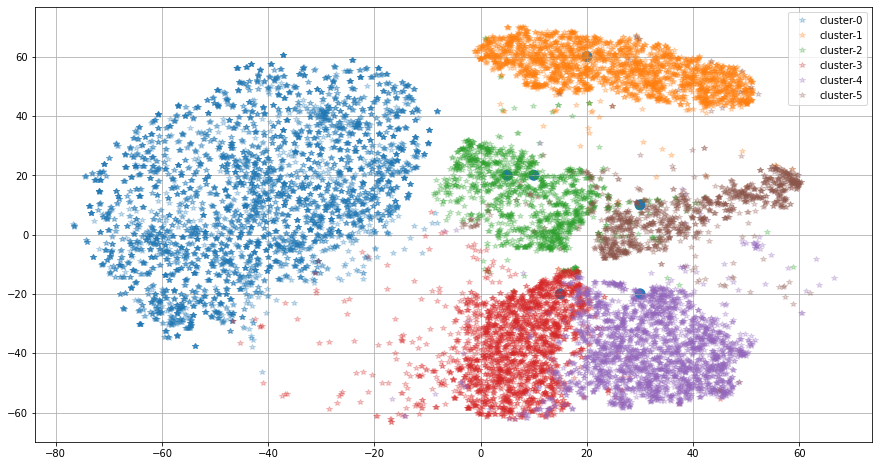

In [797]:
draw_on_proj_with_clusters(train_n_private_tsne, pred, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

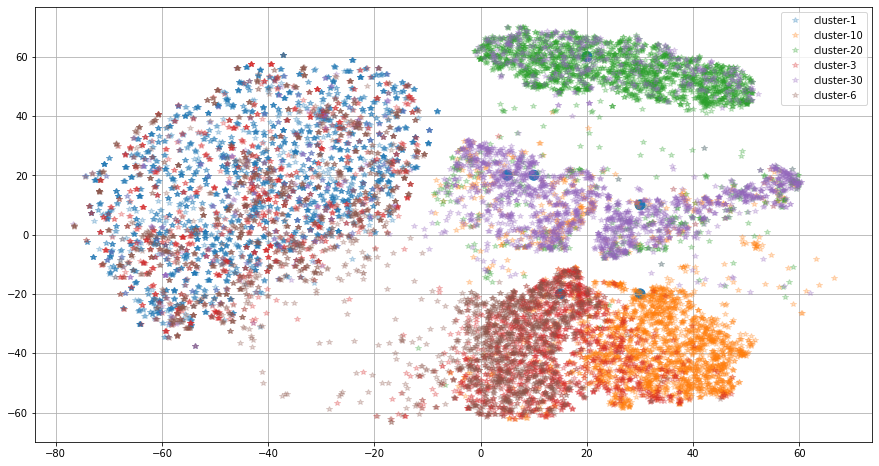

In [728]:
draw_on_proj_with_clusters(train_n_private_tsne, pred_normed, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

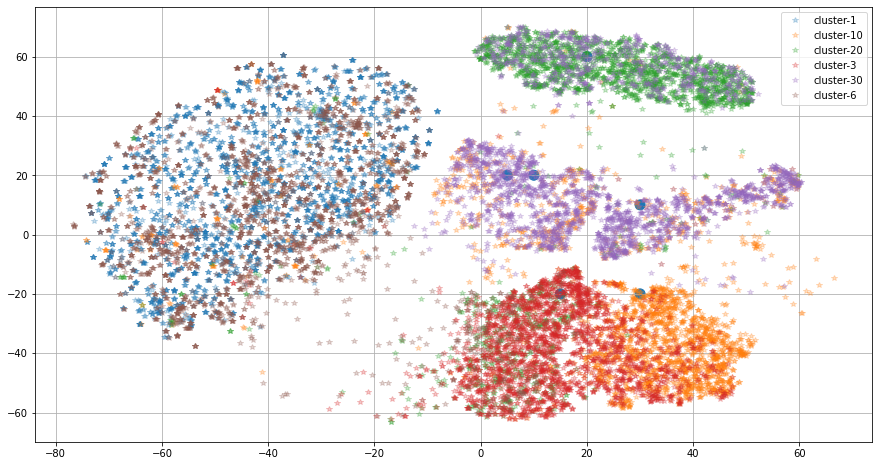

In [696]:
draw_on_proj_with_clusters(train_n_private_tsne, pred_normed, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

In [698]:
for k,v in pred_normed.items():
    m = train_n_private_tsne[N_TRAIN:][v[0]]
    print(k, np.median(m[:, 0]), np.median(m[:, 1]))

1 -42.589817 16.555578
10 32.83003 -31.170214
20 18.484648 52.35692
3 12.861907 -38.562637
30 20.640354 15.573766
6 -39.37675 7.1653857


In [665]:
for k,v in pred_normed.items():
    m = train_n_private_tsne[N_TRAIN:][v[0]]
    print(k, np.mean(m[:, 0]), np.mean(m[:, 1]))

1 -46.219177 19.766932
10 25.917952 -25.015501
20 24.758734 54.299633
3 12.025096 -41.34835
30 19.591734 8.26023
6 -31.972801 3.188593


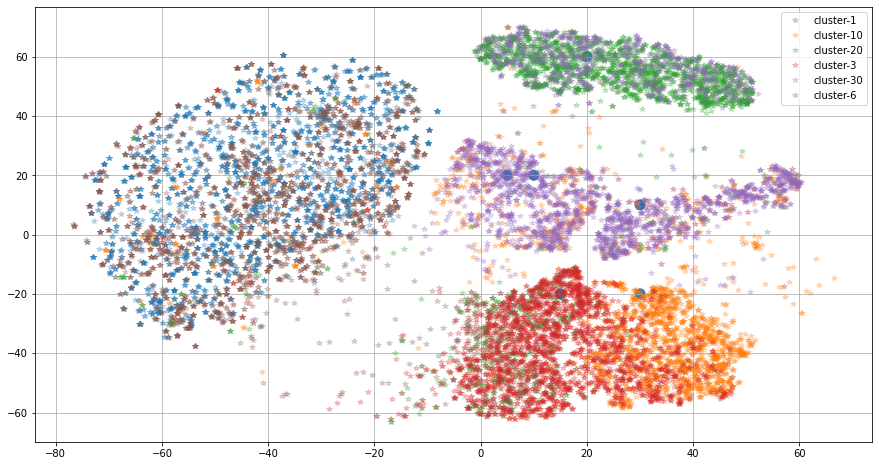

In [640]:
draw_on_proj_with_clusters(train_n_private_tsne, pred_normed, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

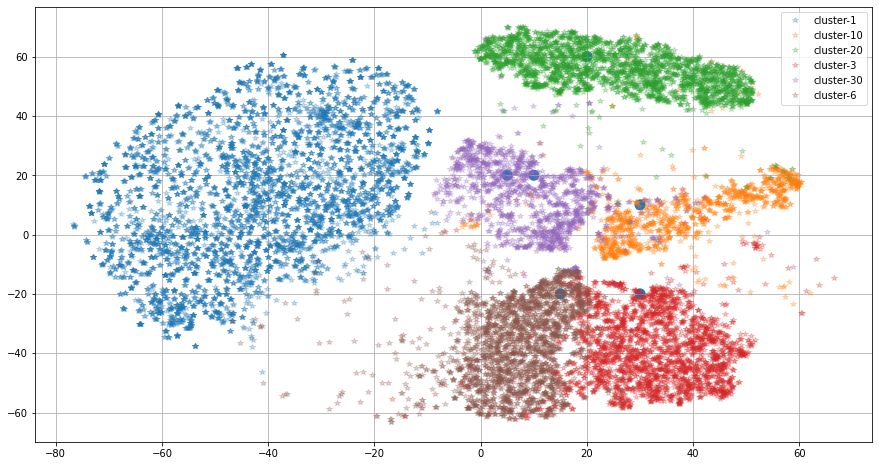

In [450]:
draw_on_proj_with_clusters(train_n_private_tsne, clusters=pred,
                           cluster_train=False,
                           without_train=True, with_private_first=True)

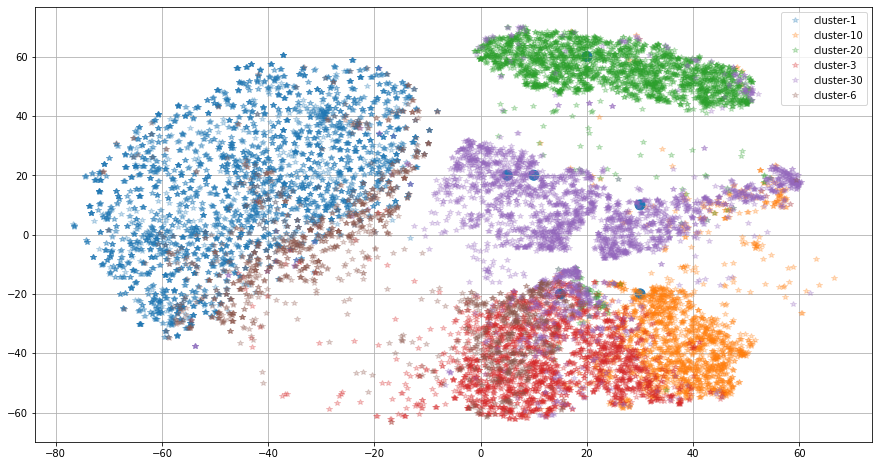

In [455]:
draw_on_proj_with_clusters(train_n_private_tsne, clusters=pred, 
                           cluster_train=False,
                           without_train=True, with_private_first=True)

In [548]:
pred

{'1': (array([    0,     1,     3, ..., 15042, 15051, 15056]),),
 '10': (array([    5,    22,    25, ..., 15009, 15048, 15057]),),
 '20': (array([    2,    17,    24, ..., 15040, 15046, 15053]),),
 '3': (array([    4,    11,    14, ..., 15049, 15050, 15055]),),
 '30': (array([    7,    35,    56, ..., 15005, 15021, 15032]),),
 '6': (array([    9,    13,    19, ..., 15047, 15052, 15054]),)}

In [549]:
[(k, len(v[0])) for k,v in pred.items()]

[('1', 4988),
 ('10', 1187),
 ('20', 2560),
 ('3', 2556),
 ('30', 1340),
 ('6', 2427)]

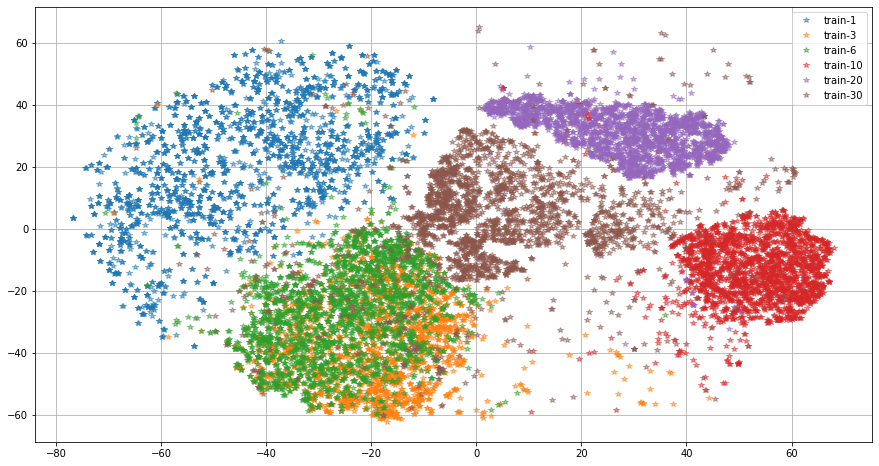

In [451]:
draw_on_proj_with_classes(train_n_private_tsne)

In [460]:
np.mean(np.abs(predictions.astype(int) - golden_predictions.astype(int)))

3.684951520786293

In [607]:
Counter([cluster2energy_mapping[x] for x in clusters])

Counter({'1': 4938, '20': 2602, '3': 2618, '30': 1376, '6': 2377, '10': 1147})